# Clean EDA/Baseline Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import time

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard # sentdex Analyzing Models with TensorBoard
                                                #- Deep Learning with Python, TensorFlow and Keras p.4, 8:20

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.optimizers import RMSprop 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os

import cv2
import PIL

from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.model_selection import train_test_split


import cv2
import PIL

import os
from os import listdir
from os.path import isfile, join

## Aptos 2019 Dataset

In [2]:
aptos = pd.read_csv('Aptos2019-Blindness-Detection-Kaggle/train.csv')
aptos_test = pd.read_csv('Aptos2019-Blindness-Detection-Kaggle/test.csv')

aptos.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
aptos.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

### Having a look at examples of DR and no DR

In [60]:
train_images = "combined-images-file/

In [61]:
img = load_img(train_images +  aptos['id_code'].iloc[1] +".png")
plt.imshow(img)
plt.title('Ploriferative DR example')
plt.axis("off")
plt.show()
img = load_img(train_images +  aptos['id_code'].iloc[3] +".png")
plt.imshow(img)
plt.title('No DR example')
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '~/Library/Mobile\\ Documents/com~apple~CloudDocs/combined-images-file001639a390f0.png.png'

### We'll have to add .png to the end of all those values in the id_label column if we're going to be able to connect them with the image files, and we'll also have to turn the diagnosis labels from into to str

In [6]:
aptos.id_code = aptos.id_code.apply(lambda x : "{}{}".format(x, ".png"))

aptos.diagnosis = aptos.diagnosis.astype(str)

type(aptos.diagnosis.iloc[0])

str

## Grabbing half the 0 labels in order to achieve class balance in the dataset

In [7]:
df_odd = aptos[aptos['diagnosis'] == '0']
df_odd.head()

,id_code,diagnosis
3,002c21358ce6.png,0
4,005b95c28852.png,0
6,0097f532ac9f.png,0
10,00cc2b75cddd.png,0
12,00f6c1be5a33.png,0


### Locating only odd rows with label 0

In [8]:
df_odd = df_odd.loc[df_odd.index % 2 == 1, :]
print(len(df_odd))

890


We have to drop the original rows containing label 0. Don't worry we'll replace them with half the original amount

In [9]:
aptos = aptos[aptos['diagnosis'] != '0']
print(aptos['diagnosis'].value_counts())

2    999
1    370
4    295
3    193
Name: diagnosis, dtype: int64


Here, see I told you we'd put half of them back in 

In [10]:
aptos = pd.concat([aptos, df_odd], ignore_index=True)
aptos['diagnosis'].value_counts()

2    999
0    890
1    370
4    295
3    193
Name: diagnosis, dtype: int64

## IDRiD DataSet

In [11]:
idrid = pd.read_csv('IDRiD-Data/Groundtruths/IDRiD_train_labels.csv')

idrid.head()

,Image name,Retinopathy grade,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Renaming our two columns of interest

In [12]:
idrid = idrid.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"})

idrid.head()

,id_code,diagnosis,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding .png to the Image names 

In [13]:
idrid['id_code'] = idrid['id_code'].apply(lambda x : "{}{}".format(x, ".png"))
idrid.head()

,id_code,diagnosis,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001.png,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002.png,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003.png,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004.png,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005.png,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Converting the Retinopathy grade to str

In [14]:
idrid['diagnosis'] = idrid['diagnosis'].astype(str)

### We're not interested in anything but the image id number (Image name) and Retinopathy grade columns. So let's drop all other columns

In [15]:
idrid = idrid[['id_code', 'diagnosis']]

idrid.head()

,id_code,diagnosis
0,IDRiD_001.png,3
1,IDRiD_002.png,3
2,IDRiD_003.png,2
3,IDRiD_004.png,3
4,IDRiD_005.png,4


That looks like our aptos df from above. That's good. Now let's see how many of each label we're working with

In [16]:
idrid.diagnosis.value_counts()

2    136
0    134
3     74
4     49
1     20
Name: diagnosis, dtype: int64

### All 0 labels

In [17]:
idrid.loc[idrid['diagnosis']== '0']

idrid.head()

,id_code,diagnosis
0,IDRiD_001.png,3
1,IDRiD_002.png,3
2,IDRiD_003.png,2
3,IDRiD_004.png,3
4,IDRiD_005.png,4


Quick look at aptos df too

In [18]:
aptos.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,0083ee8054ee.png,4
4,00a8624548a9.png,2


### There. Now we can concatenate the two DataFrames and make one dataframe

In [19]:
df = pd.concat([aptos, idrid], ignore_index = True)

df.tail(10)
# looks like the idrid dataframe is at the bottom like we wanted

,id_code,diagnosis
3150,IDRiD_404.png,2
3151,IDRiD_405.png,2
3152,IDRiD_406.png,0
3153,IDRiD_407.png,2
3154,IDRiD_408.png,1
3155,IDRiD_409.png,2
3156,IDRiD_410.png,2
3157,IDRiD_411.png,2
3158,IDRiD_412.png,2
3159,IDRiD_413.png,2


In [20]:
# let's check that aptos is at the top
df.head(10)
# it is

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,0083ee8054ee.png,4
4,00a8624548a9.png,2
5,00b74780d31d.png,2
6,00cb6555d108.png,1
7,00e4ddff966a.png,2
8,0104b032c141.png,3
9,0124dffecf29.png,1


How's the balance between classes looking

In [21]:
df['diagnosis'].value_counts()

2    1135
0    1024
1     390
4     344
3     267
Name: diagnosis, dtype: int64

Not great, but be patient, I've already gone ahead and done some work (hint: they even out)

# Bring in the Bohemoth 2015 Aptos Training Set

In [22]:
aptos15 = pd.read_csv('aptos-2015-train.csv')
aptos15.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [23]:
len(aptos15)

35126

### Let's rename the columns, for soliderity's sake

In [24]:
aptos15.rename(columns={"image": "id_code", "level": "diagnosis"}, inplace=True)

### adding jpg to the end of aptos15 id_code records and converting diagnosis column to str

In [25]:
aptos15.id_code = aptos15.id_code.apply(lambda x : "{}{}".format(x, ".jpg"))

aptos15.diagnosis = aptos15.diagnosis.astype(str)

In [26]:
aptos15.head()

,id_code,diagnosis
0,10_left.jpg,0
1,10_right.jpg,0
2,13_left.jpg,0
3,13_right.jpg,0
4,15_left.jpg,1


In [27]:
aptos15['diagnosis'].value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: diagnosis, dtype: int64

### We're going to drop the 0 labels all together for now 

In [28]:
aptos15 = aptos15[aptos15['diagnosis'] !='0']

aptos15

,id_code,diagnosis
4,15_left.jpg,1
5,15_right.jpg,2
6,16_left.jpg,4
7,16_right.jpg,4
9,17_right.jpg,1
...,...,...
35098,44323_left.jpg,1
35099,44323_right.jpg,1
35105,44328_right.jpg,1
35112,44337_left.jpg,1


## Let's Get Just Half the Rows for Diagnosis 1

In [29]:
df_even = aptos15[aptos15['diagnosis'] == '1']
df_even

df_even = df_even.loc[df_even.index % 2 == 0, :]
len(df_even)

1212

### We'll use df_even a little bit down the road

In [30]:
aptos15['diagnosis'].value_counts()

2    5292
1    2443
3     873
4     708
Name: diagnosis, dtype: int64

### Getting rid of all the diagnosis 1 rows in aptos 15 now that we have the amount in df_even that we need

In [31]:
aptos15 = aptos15[aptos15['diagnosis'] != '1']

In [32]:
aptos15['diagnosis'].value_counts()

2    5292
3     873
4     708
Name: diagnosis, dtype: int64

In [33]:
aptos15 = aptos15[aptos15['diagnosis'].isin(['3','4'])]
aptos15['diagnosis'].value_counts()

3    873
4    708
Name: diagnosis, dtype: int64

In [34]:
aptos15['diagnosis'].unique()

array(['4', '3'], dtype=object)

# We're bringing in the test data from IDRiD

In [35]:
test_idrid = pd.read_csv('IDRiD-Data/Groundtruths/IDRiD_test_labels.csv')
test_idrid = test_idrid.drop(test_idrid.columns[[2]], axis=1) # Drop Macular Adema column
test_idrid.head()

,Image name,Retinopathy grade
0,IDRiD_001,4
1,IDRiD_002,4
2,IDRiD_003,4
3,IDRiD_004,4
4,IDRiD_005,4


In [36]:
# frist change the names of columns to match other dataframes
# then add .png to image name column and turning Retinopathy grade values to str

test_idrid.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"}, inplace=True)

test_idrid['id_code'] = test_idrid['id_code'].apply(lambda x : "{}{}".format(x, ".png"))

test_idrid['diagnosis'] =  test_idrid['diagnosis'].astype(str)

test_idrid.head()

,id_code,diagnosis
0,IDRiD_001.png,4
1,IDRiD_002.png,4
2,IDRiD_003.png,4
3,IDRiD_004.png,4
4,IDRiD_005.png,4


In [37]:
test_idrid['diagnosis'].value_counts()

0    34
2    32
3    19
4    13
1     5
Name: diagnosis, dtype: int64

drop all but values 3, 4 and 0

In [38]:
test_idrid = test_idrid[test_idrid['diagnosis'].isin(['0','3','4'])]
test_idrid.head()

,id_code,diagnosis
0,IDRiD_001.png,4
1,IDRiD_002.png,4
2,IDRiD_003.png,4
3,IDRiD_004.png,4
4,IDRiD_005.png,4


In [39]:
test_idrid['diagnosis'].unique()

array(['4', '3', '0'], dtype=object)

### combing test_idrid and df

In [40]:
df = pd.concat([df, test_idrid], ignore_index=True)

df.tail()

,id_code,diagnosis
3221,IDRiD_096.png,0
3222,IDRiD_097.png,0
3223,IDRiD_098.png,0
3224,IDRiD_099.png,0
3225,IDRiD_103.png,0


In [41]:
df = pd.concat([df, test_idrid], ignore_index=True)

df.tail()

,id_code,diagnosis
3287,IDRiD_096.png,0
3288,IDRiD_097.png,0
3289,IDRiD_098.png,0
3290,IDRiD_099.png,0
3291,IDRiD_103.png,0


In [42]:
df['diagnosis'].value_counts()

2    1135
0    1092
1     390
4     370
3     305
Name: diagnosis, dtype: int64

dropping all the l labels fromt the datarame

In [43]:
df = df[df['diagnosis'] != '1']

### Enter our df_even from above. Let's combine it with df

In [44]:
df = pd.concat([df, df_even], ignore_index=True)

df['diagnosis'].value_counts()

1    1212
2    1135
0    1092
4     370
3     305
Name: diagnosis, dtype: int64

### Now combine aptos 15

In [45]:
df = pd.concat([df, aptos15], ignore_index=True )

### Hey look at that, all our labels seem to be around the same amount. All that work payed off

In [46]:
df['diagnosis'].value_counts()

1    1212
3    1178
2    1135
0    1092
4    1078
Name: diagnosis, dtype: int64

### Percentage-wise?

In [47]:
df['diagnosis'].value_counts(normalize=True)

1    0.212818
3    0.206848
2    0.199298
0    0.191747
4    0.189289
Name: diagnosis, dtype: float64

In [48]:
counts = df['diagnosis'].value_counts(normalize=True)

### A look at the Labels distribution

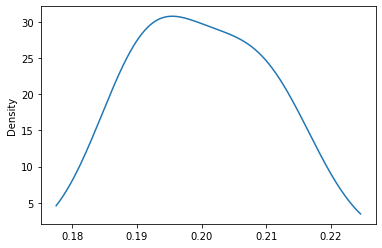

In [49]:
counts.plot.kde();

### That looks like a bell to me. Let's see the labels in bar-form

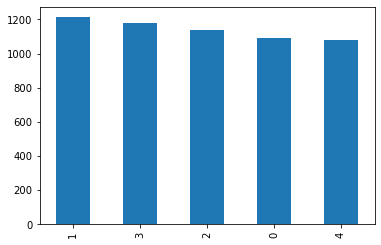

In [50]:
df['diagnosis'].value_counts().plot(kind='bar');

## Much better
the dataset looks fairly balanced, ready to run through a model I'd say

In [51]:
df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0083ee8054ee.png,4
3,00a8624548a9.png,2
4,00b74780d31d.png,2


In [52]:
len(df)

5695

## Using flow_from_dataframe( ) to create train, test, validate data

In [53]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20, # .25 to .20
                          shear_range=0.45, # .30 to .45
                          horizontal_flip=True,
                          vertical_flip=True,
                          )

# Test flow_from_dataframe
test_datagen=ImageDataGenerator(rescale=1./255.)


valgen = ImageDataGenerator(rescale=1./255., validation_split=0.20) # .25 to .20



#train_datagen = ImageDataGenerator(rescale=1./255,
                                #   shear_range=0.20,
                                  # horizontal_flip=True,
                                  # vertical_flip=True,
                                    # )
                            # fill_mode options = [wrap, nearest, constant (with color val), reflect*]
                

batch_size = 32

# Train flow_from_datafram
train_generator=datagen.flow_from_dataframe(
dataframe=df, 
directory=f"combined-images-file/",
x_col="id_code",
y_col="diagnosis",
subset="training",
batch_size=32, #  16 from 32 
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(150,150)) # make (256, 256) on Capstone_10

# Validation flow_from_dataframe
valid_generator=valgen.flow_from_dataframe(
dataframe=df,
directory=f"combined-images-file/",
x_col="id_code",
y_col="diagnosis",
subset="validation",
batch_size=32, # go to 32 on Capstone_9 *************
seed=42,
shuffle=True,  
class_mode="categorical",
target_size=(150,150)) # make (256, 256)




test_generator=test_datagen.flow_from_dataframe(
dataframe=df,
directory=f"combined-images-file/",
x_col="id_code",
y_col=None,
batch_size=1, # batch 32 to 1
seed=42,
shuffle=False,
class_mode=None,
target_size=(256,256)) # not sure if we change test sizes????

Found 4136 validated image filenames belonging to 5 classes.
Found 1033 validated image filenames belonging to 5 classes.
Found 5169 validated image filenames.


/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 526 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


In [54]:
model = Sequential()

model.add(Conv2D(32, (3, 3),  # deleted "padding='same'"
                     input_shape=(150,150,3))) # Changed 150 from 256
model.add(Activation('relu'))  # try Leaky Relu on Capstone_9*******************************************

model.add(Conv2D(32, (3, 3))) # 32 to 64 for Capstone_11
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # removed maxpooling
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3))) # deleted "padding='same'"
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # removed maxpooling for Capstone_11
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512)) 
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax')) 

# change optimzer = "adam" for Capstone_9
# momentum=0.n for RMSprop
# try dif learning rates for adam
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"]) #le-8 to le-6 changed optimizer to Adam
    



2021-09-03 13:37:24.221768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fit  Model

In [55]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15 # went from 10 to 15
)


# # uncomment to see a plot of metrics
# history = model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=10, # went from 4 to  10
#                     verbose = 2
                    
# )
# #plot metrics
# plt.plot(history.history['acc'])
# plt.show()


/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-03 13:37:44.385045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/15
129/129 [==============================] - 1612s 12s/step - loss: 4.4560 - accuracy: 0.3478 - val_loss: 1.2718 - val_accuracy: 0.5371
Epoch 2/15
129/129 [==============================] - 1744s 14s/step - loss: 0.9880 - accuracy: 0.5233 - val_loss: 1.2437 - val_accuracy: 0.5430
Epoch 3/15
129/129 [==============================] - 2502s 19s/step - loss: 0.9342 - accuracy: 0.5484 - val_loss: 1.1593 - val_accuracy: 0.5586
Epoch 4/15
129/129 [==============================] - 2565s 20s/step - loss: 0.9292 - accuracy: 0.5567 - val_loss: 1.2639 - val_accuracy: 0.5518
Epoch 5/15
 61/129 [=============>................] - ETA: 21:21 - loss: 0.8844 - accuracy: 0.5677

KeyboardInterrupt: 

## Formula for calulating steps=n

In [59]:
steps_per_epoch = len(valid_generator) // batch_size
steps_per_epoch

1

## Test Baseline

In [63]:
model.evaluate_generator(generator=valid_generator,
steps=steps_per_epoch)

[1.6883385181427002, 0.5]